In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


# TRain test split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)


In [4]:
X_train.shape

(127, 60)

# RF>XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'gbtree'**
   
   **tree_method: 'auto'**

Fitting 10 folds for each of 8748 candidates, totalling 87480 fits


e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:55] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__max_features': 'sqrt', 'xgb__n_estimators': 50, 'xgb__reg_alpha': 1, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.8}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


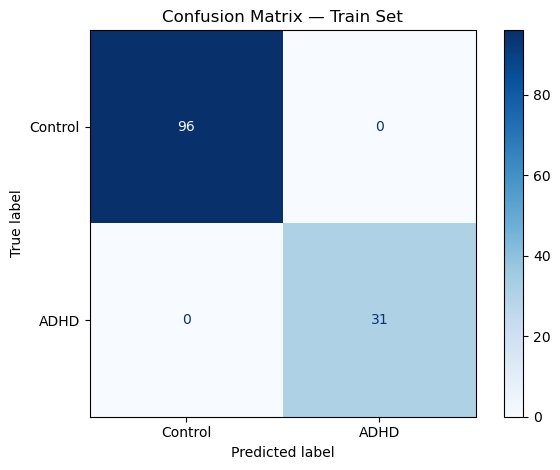

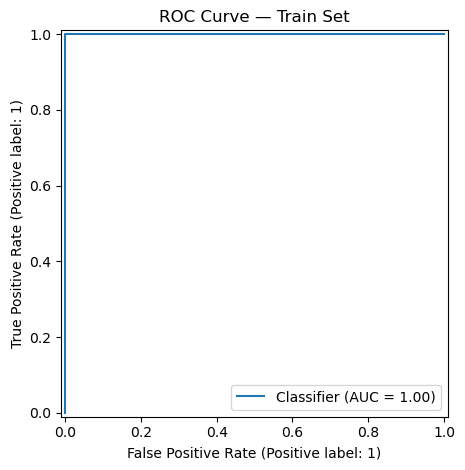

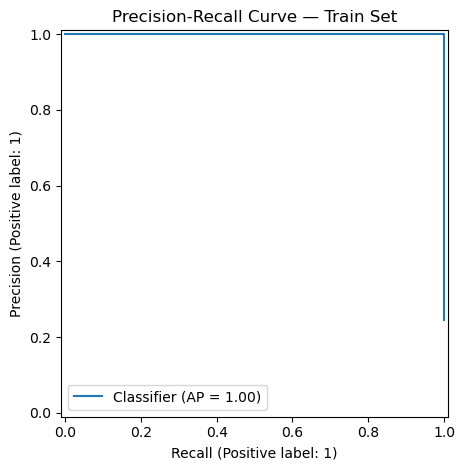

e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:58] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:59] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:43:00] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:43:00] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\cor


📊 Cross-Validated Scores:
fit_time: 0.4151
score_time: 0.0721
test_accuracy: 0.6983
train_accuracy: 0.9993
test_precision_macro: 0.4878
train_precision_macro: 0.9986
test_recall_macro: 0.5208
train_recall_macro: 0.9995
test_f1_macro: 0.4996
train_f1_macro: 0.9991
test_roc_auc: 0.6444
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.82      0.96      0.88        24
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.81        32
   macro avg       0.79      0.67      0.69        32
weighted avg       0.80      0.81      0.79        32

ROC AUC (Test): 0.7760416666666666


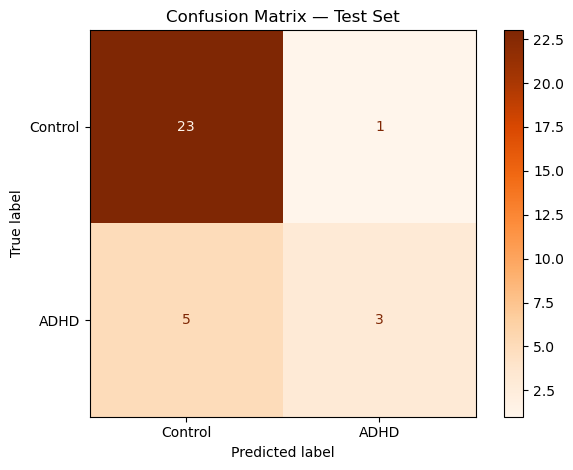

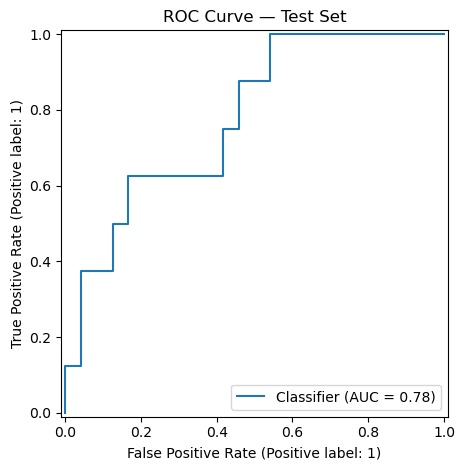

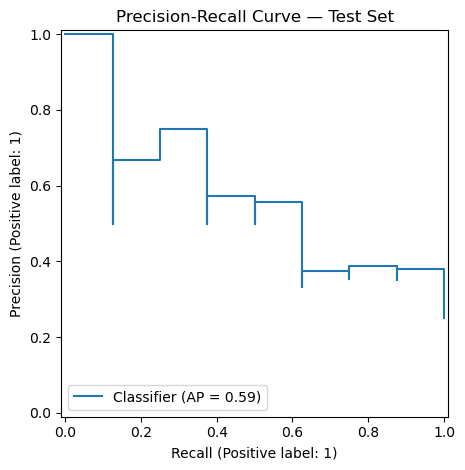

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=16
)

# === XGBoost Classifier ===
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('xgb', xgb_model)
])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    'xgb__max_features': ['sqrt', 'log2']
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'gbtree'**
   
   **tree_method: 'auto'**

Fitting 10 folds for each of 8748 candidates, totalling 87480 fits


e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:23] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__max_features': 'sqrt', 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.3, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.6}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


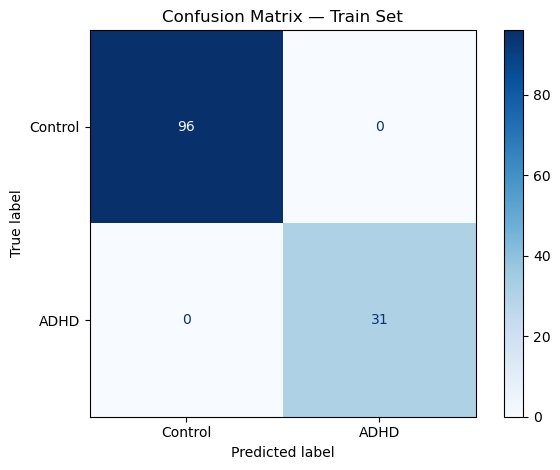

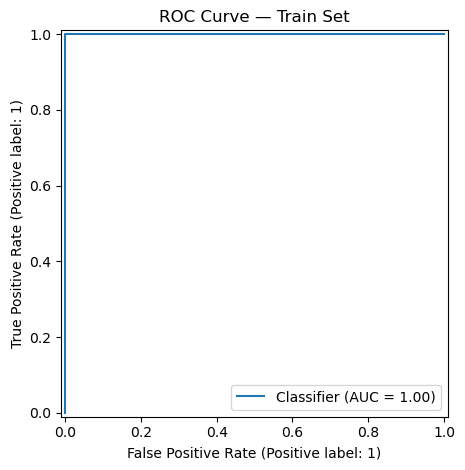

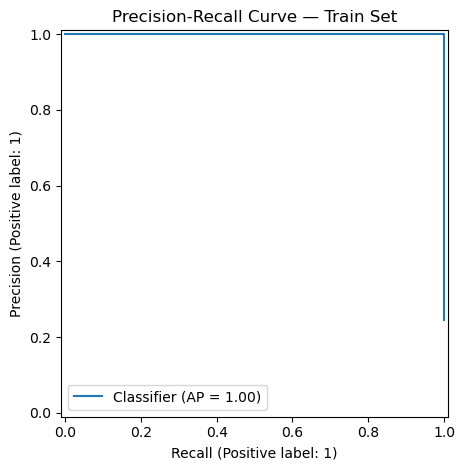

e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:24] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:25] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:25] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:25] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
e:\anaconda\envs\basic\Lib\site-packages\xgboost\cor


📊 Cross-Validated Scores:
fit_time: 0.2478
score_time: 0.0970
test_accuracy: 0.6983
train_accuracy: 1.0000
test_precision_macro: 0.5023
train_precision_macro: 1.0000
test_recall_macro: 0.5333
train_recall_macro: 1.0000
test_f1_macro: 0.5147
train_f1_macro: 1.0000
test_roc_auc: 0.6854
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.88      0.92      0.90        24
        ADHD       0.71      0.62      0.67         8

    accuracy                           0.84        32
   macro avg       0.80      0.77      0.78        32
weighted avg       0.84      0.84      0.84        32

ROC AUC (Test): 0.8697916666666667


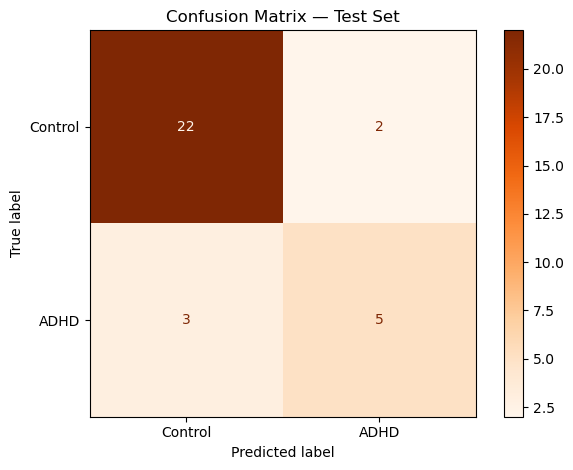

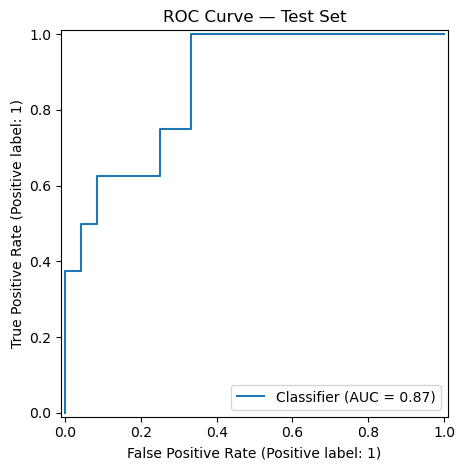

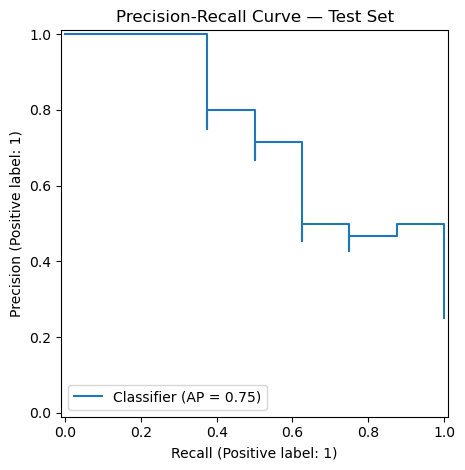

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# === XGBoost Classifier ===
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    'xgb__max_features': ['sqrt', 'log2']
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'gbtree'**
   
   **tree_method: 'exact'**

Fitting 10 folds for each of 4374 candidates, totalling 43740 fits
✅ Best Params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 5, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.8}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


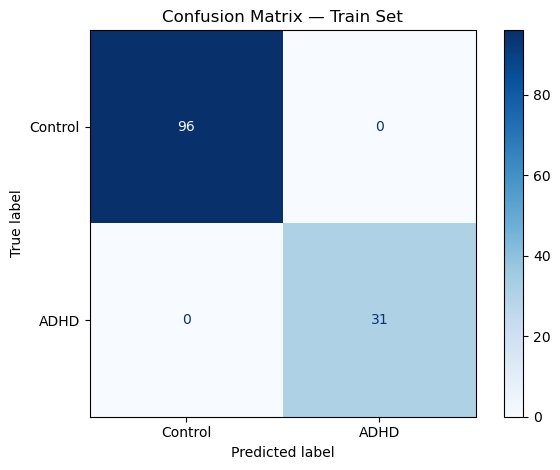

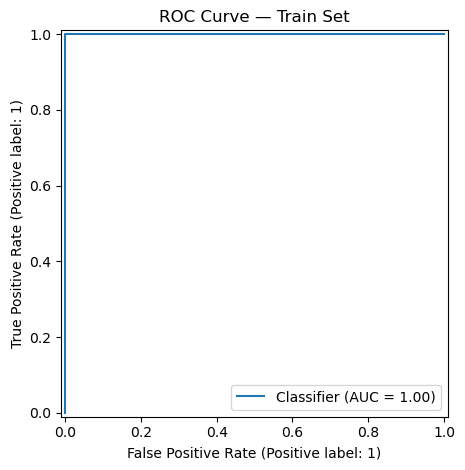

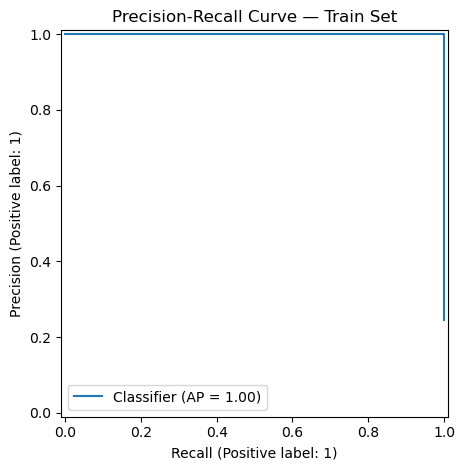

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.1016
score_time: 0.0904
test_accuracy: 0.7175
train_accuracy: 0.9979
test_precision_macro: 0.5254
train_precision_macro: 0.9959
test_recall_macro: 0.5458
train_recall_macro: 0.9986
test_f1_macro: 0.5305
train_f1_macro: 0.9972
test_roc_auc: 0.6340
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.77      0.96      0.85        24
        ADHD       0.50      0.12      0.20         8

    accuracy                           0.75        32
   macro avg       0.63      0.54      0.53        32
weighted avg       0.70      0.75      0.69        32

ROC AUC (Test): 0.8489583333333333


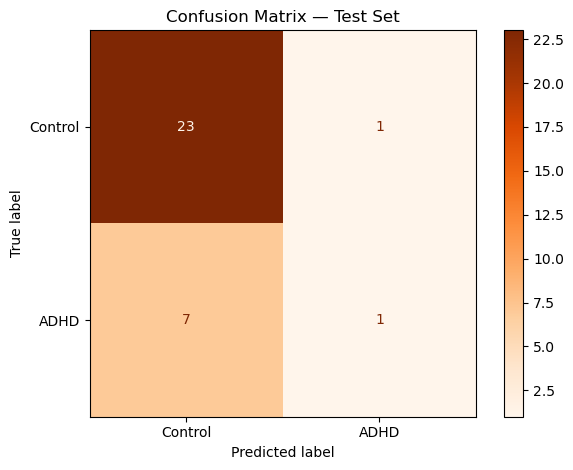

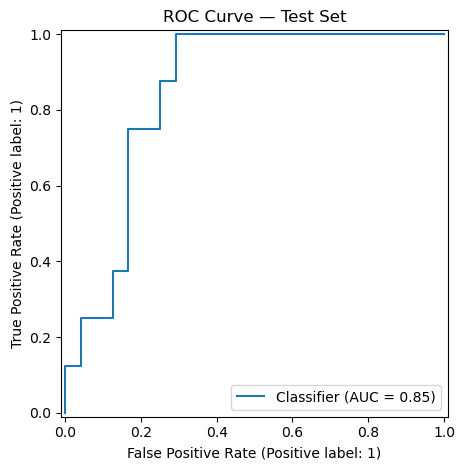

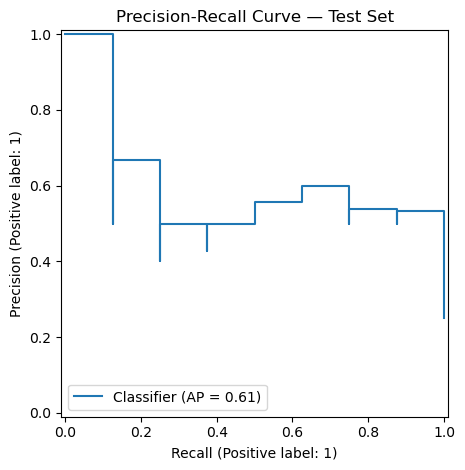

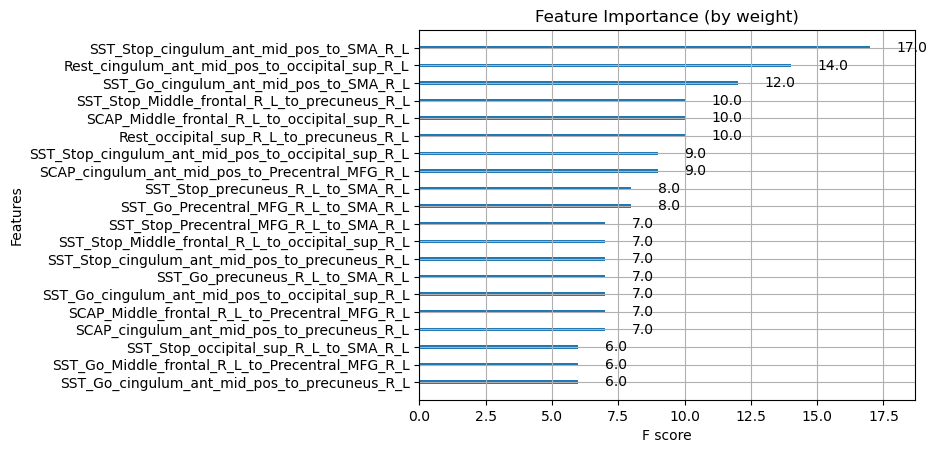

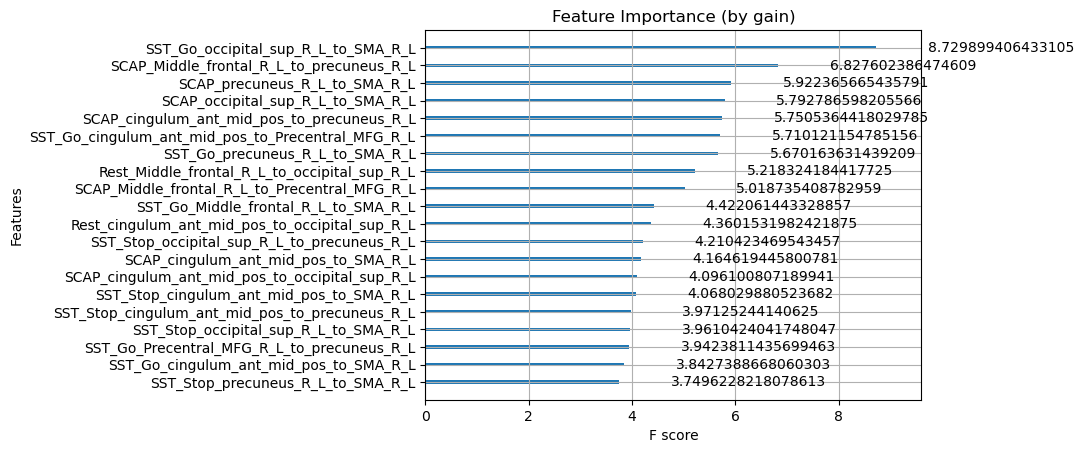

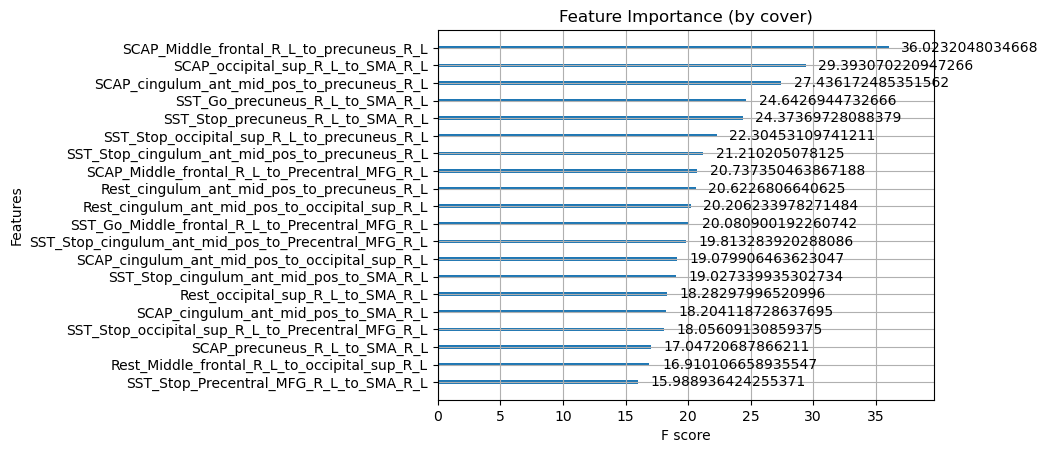

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# === XGBoost Classifier with booster='gbtree' and tree_method='exact' ===
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    tree_method='exact',
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


#===plotting feature importance of best model===

# Extract the best XGBoost model from the pipeline
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

# Plot feature importance (default: based on weight)
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.show()

# You can also plot by other importance types, e.g., 'gain' or 'cover':
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.show()





# XGB  : 
**objective: 'binary:logistic'**

   **booster: 'gbtree'**
   
   **tree_method: 'hist'**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb
import shap  # NEW: SHAP for explainability

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === XGBoost Classifier with booster='gbtree' and tree_method='hist' ===
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    tree_method='hist',
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Only XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Class imbalance weight ===
scale_pos_weight_val = (len(y_train) - sum(y_train)) / sum(y_train)

# === Wide Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],
    'xgb__reg_lambda': [1, 2, 5, 10],
    'xgb__scale_pos_weight': [scale_pos_weight_val]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()

# === Feature Importance (Built-In XGBoost) ===
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.tight_layout()
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.tight_layout()
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.tight_layout()
plt.show()

# === SHAP Feature Importance ===
print("\n🧠 SHAP Summary Plot (Feature Importance)")
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)


Fitting 10 folds for each of 17280 candidates, totalling 172800 fits


# XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'dart'**
   
   **tree_method: 'auto'**

Fitting 10 folds for each of 4374 candidates, totalling 43740 fits
✅ Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.7, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.8}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


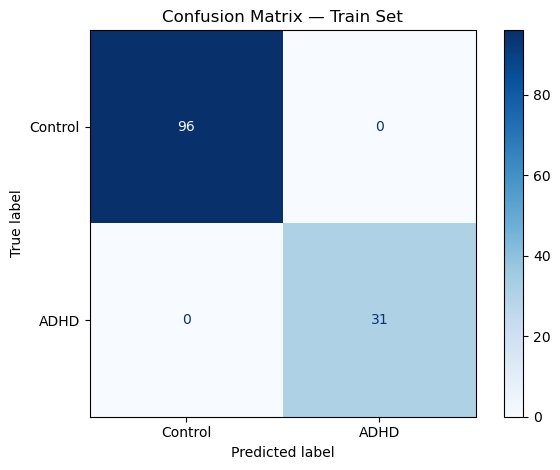

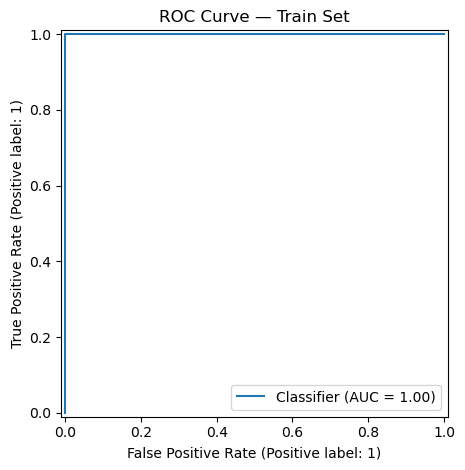

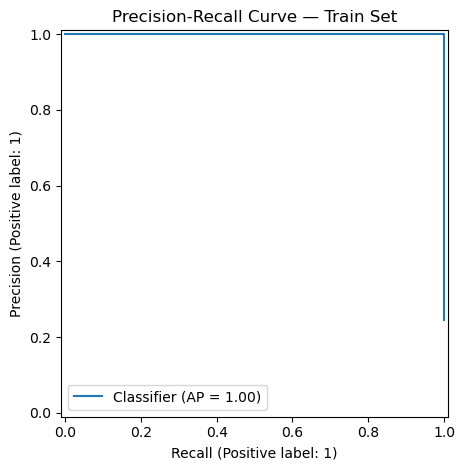

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 1.0850
score_time: 0.0939
test_accuracy: 0.7421
train_accuracy: 1.0000
test_precision_macro: 0.5560
train_precision_macro: 1.0000
test_recall_macro: 0.5542
train_recall_macro: 1.0000
test_f1_macro: 0.5348
train_f1_macro: 1.0000
test_roc_auc: 0.6576
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.82      0.96      0.88        24
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.81        32
   macro avg       0.79      0.67      0.69        32
weighted avg       0.80      0.81      0.79        32

ROC AUC (Test): 0.890625


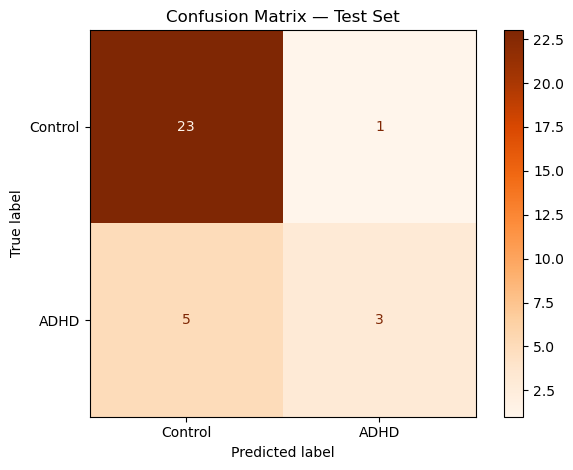

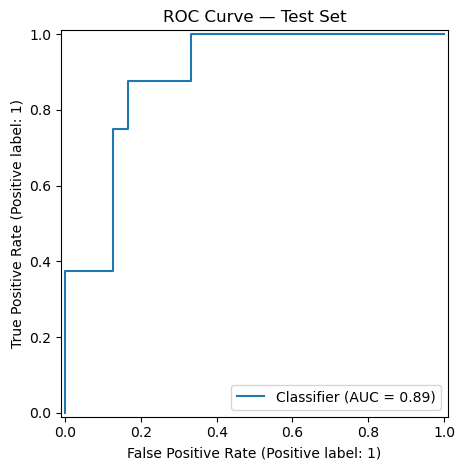

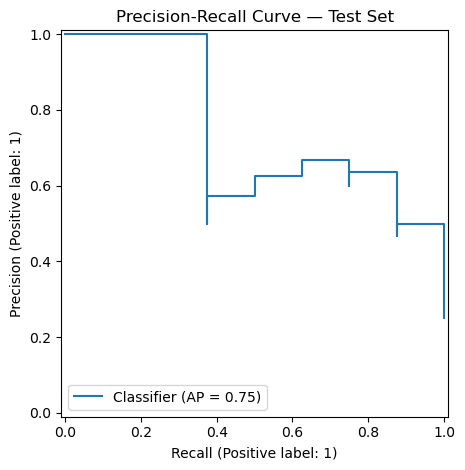

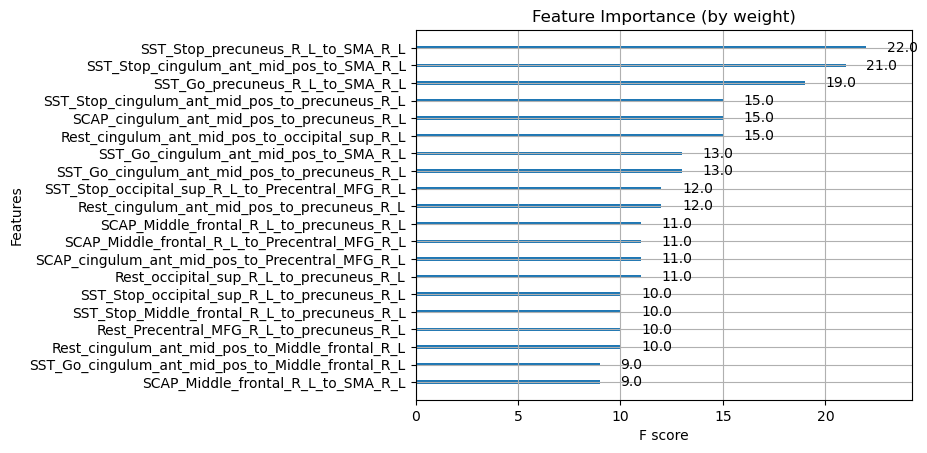

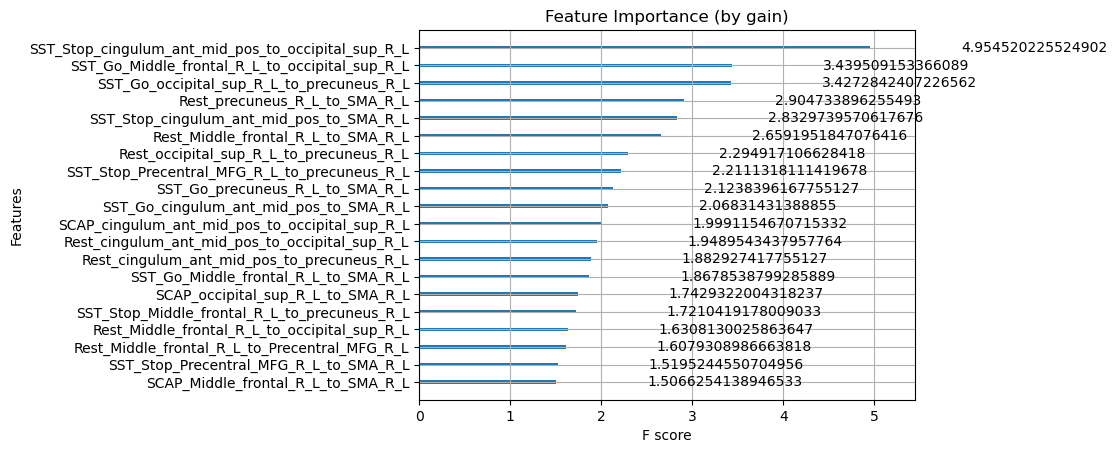

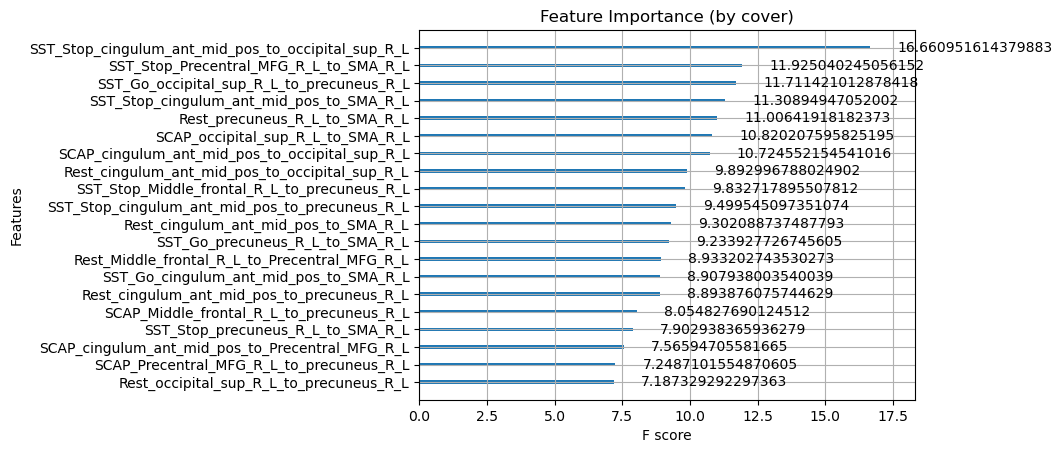

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# === XGBoost Classifier with booster='dart' and tree_method='auto' ===
xgb_model = xgb.XGBClassifier(
    booster='dart',
    tree_method='auto',
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


#===plotting feature importance of best model===

# Extract the best XGBoost model from the pipeline
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

# Plot feature importance (default: based on weight)
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.show()

# You can also plot by other importance types, e.g., 'gain' or 'cover':
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.show()


# XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'dart'**
   
   **tree_method: 'exact'**

Fitting 10 folds for each of 4374 candidates, totalling 43740 fits
✅ Best Params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.8}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


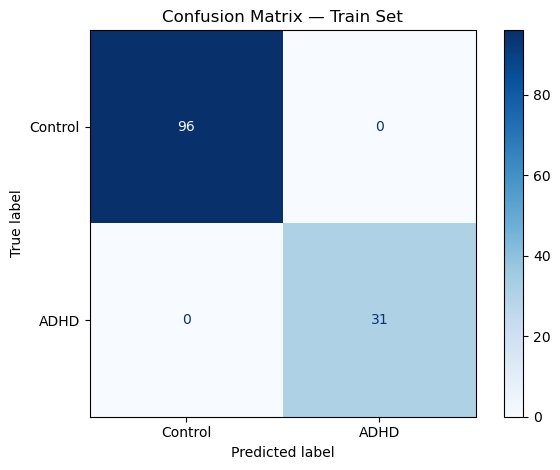

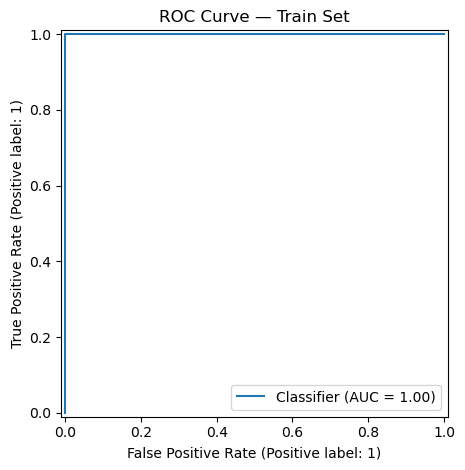

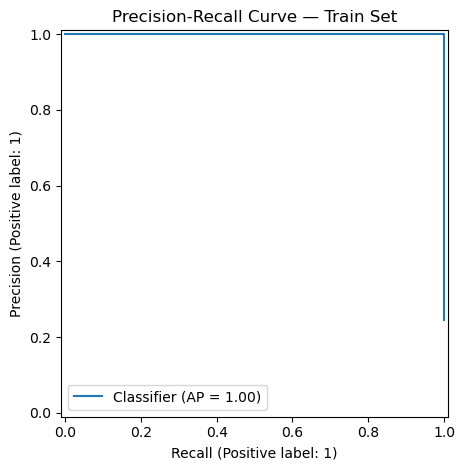

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.2136
score_time: 0.0903
test_accuracy: 0.7108
train_accuracy: 0.9909
test_precision_macro: 0.5361
train_precision_macro: 0.9826
test_recall_macro: 0.5208
train_recall_macro: 0.9940
test_f1_macro: 0.5076
train_f1_macro: 0.9880
test_roc_auc: 0.6333
train_roc_auc: 0.9999

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.82      0.96      0.88        24
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.81        32
   macro avg       0.79      0.67      0.69        32
weighted avg       0.80      0.81      0.79        32

ROC AUC (Test): 0.8697916666666667


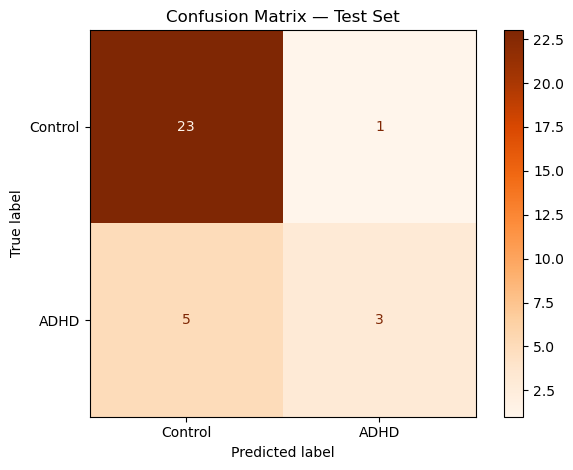

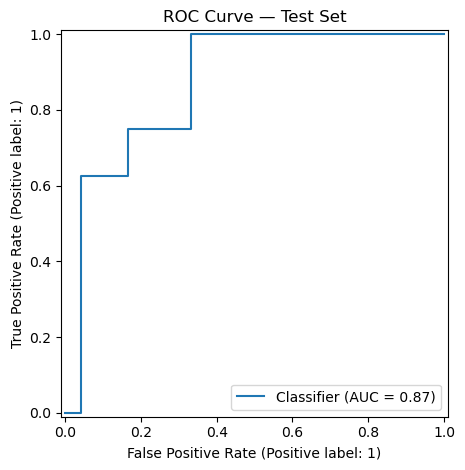

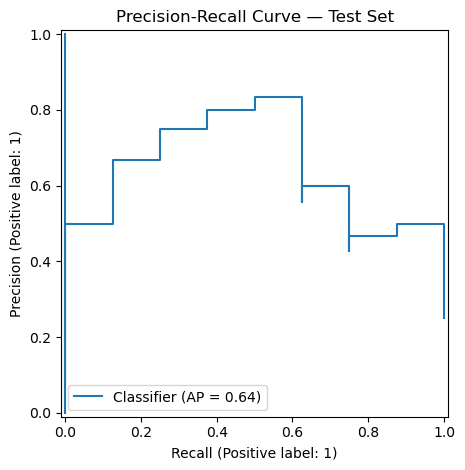

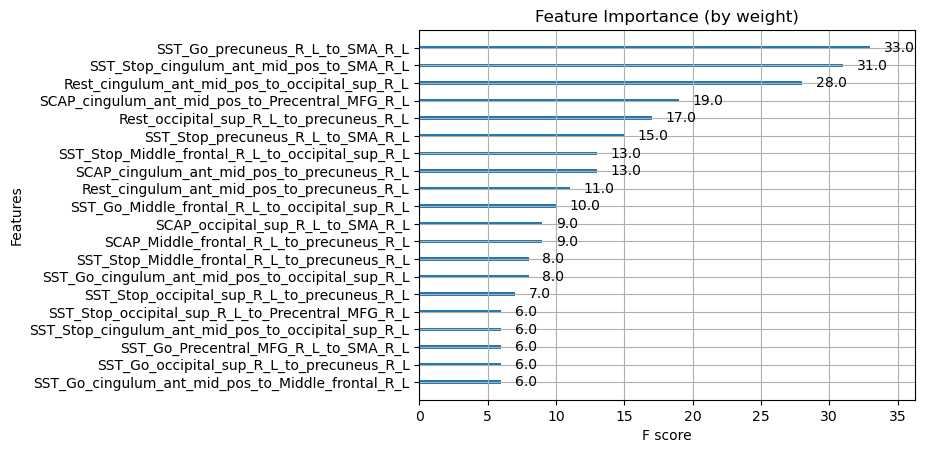

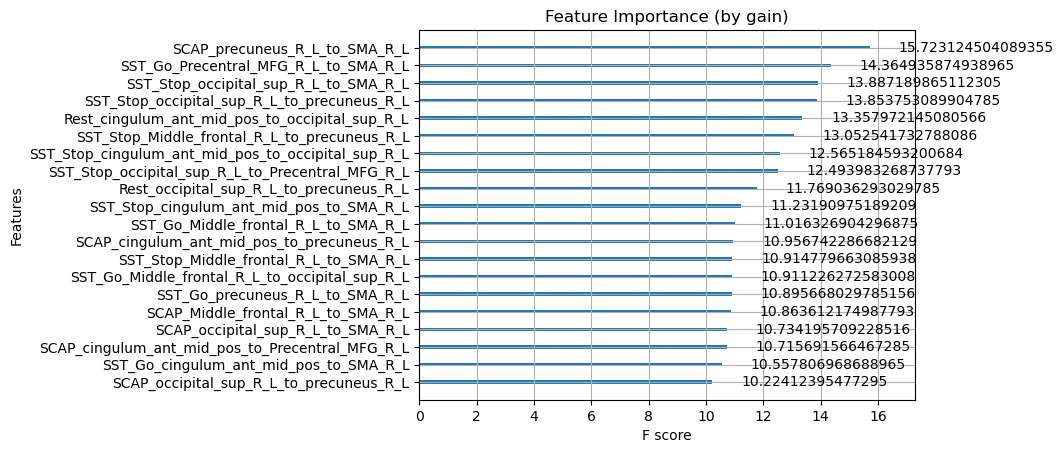

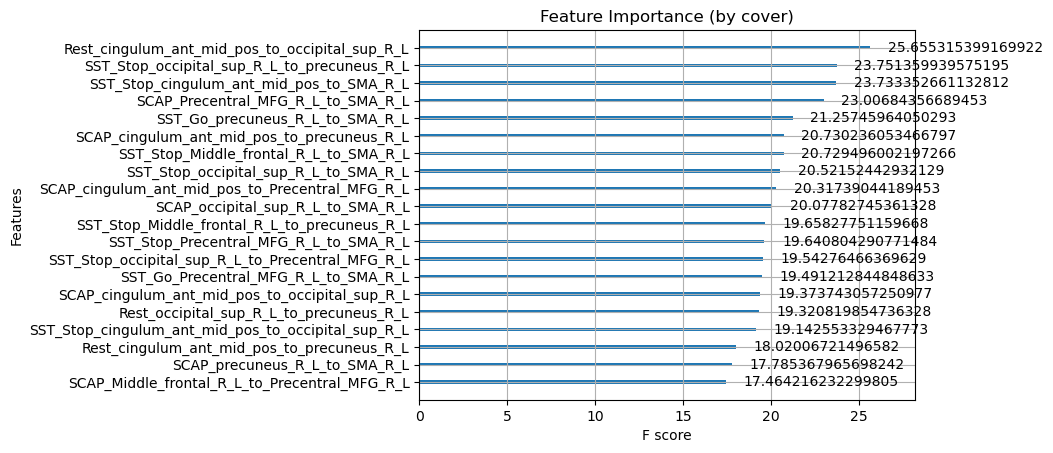

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# === XGBoost Classifier with booster='dart' and tree_method='exact' ===
xgb_model = xgb.XGBClassifier(
    booster='dart',
    tree_method='exact',
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


#===plotting feature importance of best model===
# Extract the best XGBoost model from the pipeline
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

# Plot feature importance (default: based on weight)
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.show()

# You can also plot by other importance types, e.g., 'gain' or 'cover':
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.show()

# XGB  :   
   **objective: 'binary:logistic'**

   **booster: 'dart'**
   
   **tree_method: 'hist'**

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb
import shap  # SHAP for explainability

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === XGBoost Classifier with booster='dart' and tree_method='hist' ===
xgb_model = xgb.XGBClassifier(
    booster='dart',
    tree_method='hist',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# === Pipeline: Only XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Class imbalance weight ===
scale_pos_weight_val = (len(y_train) - sum(y_train)) / sum(y_train)

# === Wide Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],
    'xgb__reg_lambda': [1, 2, 5, 10],
    'xgb__scale_pos_weight': [scale_pos_weight_val]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()

# === Feature Importance (Built-In XGBoost) ===
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.tight_layout()
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.tight_layout()
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.tight_layout()
plt.show()

# === SHAP Feature Importance ===
print("\n🧠 SHAP Summary Plot (Feature Importance)")
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)


Fitting 10 folds for each of 17280 candidates, totalling 172800 fits
